In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import VAE,AEBase
from models import DNN
import numpy as np
import pandas as pd
import models
import utils as ut
import copy



In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [2]:
from scipy.stats import pearsonr

# Parameters

In [3]:
# Define parameters
epochs = 500 #200,500,1000  
#dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
select_drug = 'Gefitinib'
na = -1

# Import data

In [4]:
data_r=pd.read_csv('data/GDSCexpression.csv',index_col=0)
label_r=pd.read_csv('data/GDSClabel.csv',index_col=0)

In [5]:
label_r=label_r.fillna(na)

In [6]:
hvg,adata = ut.highly_variable_genes(data_r)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
label_r

,Erlotinib,AICAR,Camptothecin,Vinblastine,Cisplatin,Cytarabine,Docetaxel,Methotrexate,ATRA,Gefitinib,...,CMK,Pyrimethamine,JW-7-52-1,A-443654,GW843682X,MS-275,Parthenolide,MG-132,KIN001-135,TGX221
BxPC-3,-1.000000,0.159708,0.188393,0.436127,0.154274,0.113764,0.249987,0.015324,0.015324,0.020293,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
KMOE-2,0.002108,0.339814,0.318206,0.281740,0.063808,0.140681,0.101530,0.191210,0.031229,0.007419,...,0.022662,0.025217,0.270791,0.095608,0.139914,0.171747,0.026670,0.013904,0.002116,0.000956
MFM-223,0.002148,0.334087,0.122671,0.361438,0.051983,0.186659,0.228797,0.003639,0.023043,0.003639,...,0.038997,0.006167,0.002185,0.102592,0.020338,0.010874,0.000970,0.035206,0.007051,0.000323
NUGC-3,-1.000000,0.095099,0.416792,0.422631,0.266409,0.237811,0.234952,0.011558,0.028838,0.153002,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
OC-314,-1.000000,0.012740,0.479915,0.390145,0.067738,0.125869,0.249668,0.110418,0.002214,0.020309,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KP-N-S19s,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
BC-3,0.003515,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.048227,0.146476,0.400087,0.205247,0.147090,0.298803,0.023796,0.017219,0.002065,0.069181
Panc 08.13,-1.000000,0.152818,0.196279,0.180653,0.090963,0.093197,0.097267,0.018269,0.010237,0.009405,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
EKVX,0.177238,0.078395,0.078938,0.072213,0.007225,0.003470,0.129184,0.095642,0.111598,0.126364,...,0.020472,0.044047,0.243635,0.079375,0.019859,0.177759,0.014843,0.114431,0.007216,0.063911


In [8]:
selected_idx = label_r.loc[:,select_drug]!=na

In [9]:
data_r.columns = adata.var_names

# Your is gene-cell, mine is cell-gene

In [10]:
data = data_r.loc[selected_idx,hvg]

In [11]:
label = label_r.loc[selected_idx,select_drug]
#sscaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
mmscaler = preprocessing.MinMaxScaler()

data = mmscaler.fit_transform(data)
#data = sscaler.fit_transform(data)


In [12]:
print(np.std(data))
print(np.mean(data))

0.25383929199289434
0.2727100504700379


In [13]:
data.mean(axis=0)


array([0.49458949, 0.09860014, 0.21159545, ..., 0.21276445, 0.22738253,
       0.27747885])

In [14]:
print(data.max())
print(data.min())

1.0000000000000004
0.0


In [15]:
data.shape

(675, 3462)

In [16]:
label_r.shape

(789, 139)

# Split test train

In [17]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, Y_train_all, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=42)

In [18]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(675, 3462)
(675,)
(432, 3462) (432,)
(135, 3462) (135,)


In [19]:
print(X_train.max())
print(X_train.min())

1.0000000000000002
0.0


# AE MODEL

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [21]:
X_trainTensor = torch.FloatTensor(X_train).to(device)
X_validTensor = torch.FloatTensor(X_valid).to(device)
X_testTensor = torch.FloatTensor(X_test).to(device)
X_allTensor = torch.FloatTensor(data).to(device)
#X_alltrainTensor = torch.FloatTensor(X_train_all).to(device)


Y_trainTensor = torch.FloatTensor(Y_train.values).to(device)
Y_validTensor = torch.FloatTensor(Y_valid.values).to(device)

# construct TensorDataset
train_dataset = TensorDataset(X_trainTensor, X_trainTensor)
valid_dataset = TensorDataset(X_validTensor, X_validTensor)
test_dataset = TensorDataset(X_testTensor, X_testTensor)
all_dataset = TensorDataset(X_allTensor, X_allTensor)

X_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)
X_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=200, shuffle=True)
X_allDataLoader = DataLoader(dataset=all_dataset, batch_size=200, shuffle=True)

In [22]:
dataloader = X_trainDataLoader

In [23]:
dataloaders_train = {'train':X_trainDataLoader,'val':X_validDataLoader}

In [24]:
X_trainDataLoader.dataset.tensors[0].shape[0]

432

In [25]:
{x: dataloaders_train[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}

{'train': 432, 'val': 108}

# The model

In [26]:
model = AEBase(input_dim=data.shape[1],latent_dim=512,hidden_dims=[1024,512,256])

In [27]:
print(model)

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3462, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-0

In [28]:
#model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    model.cuda()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [29]:
def train_ae_model(net,data_loaders,optimizer,loss_function,n_epochs,scheduler):
    
    dataset_sizes = {x: data_loaders[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}
    loss_train = {}
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = np.inf

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = scheduler(optimizer, epoch)
                net.train()  # Set model to training mode
            else:
                net.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # for data in data_loaders[phase]:
            for batchidx, (x, _) in enumerate(data_loaders[phase]):

                x.requires_grad_(True)
                # encode and decode 
                output = model(x)
                # compute loss
                loss = loss_function(output, x)      

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()
            
            # Schedular
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            loss_train[epoch,phase] = epoch_loss 
            print('{} Loss: {:.8f}'.format(phase, epoch_loss))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    
    # Select best model wts
    torch.save(best_model_wts, 'saved/models/ae.pkl')
    net.load_state_dict(best_model_wts)           
    
    return net, loss_train

In [30]:
model,loss_report = train_ae_model(net=model,data_loaders=dataloaders_train,
                             optimizer=optimizer,loss_function=loss_function,
                            n_epochs=epochs,scheduler=exp_lr_scheduler)

Epoch 0/499
----------
train Loss: 0.00093345
val Loss: 0.00101526
Epoch 1/499
----------
train Loss: 0.00081894
val Loss: 0.00095026
Epoch 2/499
----------
train Loss: 0.00078748
val Loss: 0.00098939
Epoch 3/499
----------
train Loss: 0.00074839
val Loss: 0.00098055
Epoch 4/499
----------
train Loss: 0.00073421
val Loss: 0.00097101
Epoch 5/499
----------
train Loss: 0.00072094
val Loss: 0.00096392
Epoch 6/499
----------
train Loss: 0.00069258
val Loss: 0.00090361
Epoch 7/499
----------
train Loss: 0.00069430
val Loss: 0.00087363
Epoch 8/499
----------
train Loss: 0.00067177
val Loss: 0.00086412
Epoch 9/499
----------
train Loss: 0.00065384
val Loss: 0.00079331
Epoch 10/499
----------
train Loss: 0.00063410
val Loss: 0.00077501
Epoch 11/499
----------
train Loss: 0.00064146
val Loss: 0.00076661
Epoch 12/499
----------
train Loss: 0.00061702
val Loss: 0.00076201
Epoch 13/499
----------
train Loss: 0.00062349
val Loss: 0.00074969
Epoch 14/499
----------
train Loss: 0.00062530
val Loss: 0

val Loss: 0.00070478
Epoch 123/499
----------
train Loss: 0.00060365
val Loss: 0.00070699
Epoch 124/499
----------
train Loss: 0.00058961
val Loss: 0.00070755
Epoch 125/499
----------
train Loss: 0.00058099
val Loss: 0.00070616
Epoch 126/499
----------
train Loss: 0.00060518
val Loss: 0.00070335
Epoch 127/499
----------
train Loss: 0.00059305
val Loss: 0.00070476
Epoch 128/499
----------
train Loss: 0.00058404
val Loss: 0.00070520
Epoch 129/499
----------
train Loss: 0.00058715
val Loss: 0.00070457
Epoch 130/499
----------
train Loss: 0.00059303
val Loss: 0.00070737
Epoch 131/499
----------
train Loss: 0.00060113
val Loss: 0.00071190
Epoch 132/499
----------
train Loss: 0.00058828
val Loss: 0.00071411
Epoch 133/499
----------
train Loss: 0.00058450
val Loss: 0.00071299
Epoch 134/499
----------
train Loss: 0.00059531
val Loss: 0.00071368
Epoch 135/499
----------
train Loss: 0.00058313
val Loss: 0.00071255
Epoch 136/499
----------
train Loss: 0.00058448
val Loss: 0.00071030
Epoch 137/499

val Loss: 0.00071194
Epoch 243/499
----------
train Loss: 0.00059383
val Loss: 0.00071296
Epoch 244/499
----------
train Loss: 0.00058081
val Loss: 0.00071345
Epoch 245/499
----------
train Loss: 0.00059004
val Loss: 0.00070858
Epoch 246/499
----------
train Loss: 0.00059007
val Loss: 0.00070542
Epoch 247/499
----------
train Loss: 0.00057824
val Loss: 0.00070741
Epoch 248/499
----------
train Loss: 0.00062320
val Loss: 0.00070949
Epoch 249/499
----------
train Loss: 0.00059346
val Loss: 0.00070794
Epoch 250/499
----------
train Loss: 0.00059227
val Loss: 0.00070621
Epoch 251/499
----------
train Loss: 0.00058749
val Loss: 0.00070482
Epoch 252/499
----------
train Loss: 0.00059269
val Loss: 0.00070243
Epoch 253/499
----------
train Loss: 0.00058037
val Loss: 0.00070465
Epoch 254/499
----------
train Loss: 0.00059901
val Loss: 0.00070789
Epoch 255/499
----------
train Loss: 0.00059047
val Loss: 0.00070783
Epoch 256/499
----------
train Loss: 0.00059178
val Loss: 0.00070504
Epoch 257/499

val Loss: 0.00070407
Epoch 363/499
----------
train Loss: 0.00058685
val Loss: 0.00070667
Epoch 364/499
----------
train Loss: 0.00057975
val Loss: 0.00070820
Epoch 365/499
----------
train Loss: 0.00059295
val Loss: 0.00070604
Epoch 366/499
----------
train Loss: 0.00058761
val Loss: 0.00070720
Epoch 367/499
----------
train Loss: 0.00057838
val Loss: 0.00070818
Epoch 368/499
----------
train Loss: 0.00058367
val Loss: 0.00071065
Epoch 369/499
----------
train Loss: 0.00059331
val Loss: 0.00071096
Epoch 370/499
----------
train Loss: 0.00059428
val Loss: 0.00071023
Epoch 371/499
----------
train Loss: 0.00059161
val Loss: 0.00071051
Epoch 372/499
----------
train Loss: 0.00058301
val Loss: 0.00070983
Epoch 373/499
----------
train Loss: 0.00058859
val Loss: 0.00071152
Epoch 374/499
----------
train Loss: 0.00059696
val Loss: 0.00070737
Epoch 375/499
----------
train Loss: 0.00058562
val Loss: 0.00070820
Epoch 376/499
----------
train Loss: 0.00058400
val Loss: 0.00070778
Epoch 377/499

train Loss: 0.00058128
val Loss: 0.00070745
Epoch 483/499
----------
train Loss: 0.00059847
val Loss: 0.00070535
Epoch 484/499
----------
train Loss: 0.00059225
val Loss: 0.00070842
Epoch 485/499
----------
train Loss: 0.00065216
val Loss: 0.00071298
Epoch 486/499
----------
train Loss: 0.00058625
val Loss: 0.00071058
Epoch 487/499
----------
train Loss: 0.00058650
val Loss: 0.00071043
Epoch 488/499
----------
train Loss: 0.00058716
val Loss: 0.00071377
Epoch 489/499
----------
train Loss: 0.00058746
val Loss: 0.00070979
Epoch 490/499
----------
train Loss: 0.00058763
val Loss: 0.00070820
Epoch 491/499
----------
train Loss: 0.00058441
val Loss: 0.00070868
Epoch 492/499
----------
train Loss: 0.00060279
val Loss: 0.00070829
Epoch 493/499
----------
train Loss: 0.00059013
val Loss: 0.00070675
Epoch 494/499
----------
train Loss: 0.00059097
val Loss: 0.00070769
Epoch 495/499
----------
train Loss: 0.00059380
val Loss: 0.00071045
Epoch 496/499
----------
train Loss: 0.00059101
val Loss: 0

In [31]:
loss_report

{(0, 'train'): 0.0009334548204033463,
 (0, 'val'): 0.001015255641606119,
 (1, 'train'): 0.0008189371373090479,
 (1, 'val'): 0.0009502593289922785,
 (2, 'train'): 0.0007874847700198492,
 (2, 'val'): 0.0009893872257735995,
 (3, 'train'): 0.0007483921772627919,
 (3, 'val'): 0.0009805488365667839,
 (4, 'train'): 0.0007342083069185416,
 (4, 'val'): 0.0009710087820335671,
 (5, 'train'): 0.0007209400473921387,
 (5, 'val'): 0.0009639176919504449,
 (6, 'train'): 0.0006925836895351056,
 (6, 'val'): 0.0009036053799920612,
 (7, 'train'): 0.0006942994616649769,
 (7, 'val'): 0.000873628106934053,
 (8, 'train'): 0.0006717746490957561,
 (8, 'val'): 0.0008641194414209436,
 (9, 'train'): 0.0006538415500135334,
 (9, 'val'): 0.0007933125037837912,
 (10, 'train'): 0.0006340999087249791,
 (10, 'val'): 0.0007750088417971576,
 (11, 'train'): 0.0006414561325477229,
 (11, 'val'): 0.000766613969096431,
 (12, 'train'): 0.000617018141956241,
 (12, 'val'): 0.0007620117868538256,
 (13, 'train'): 0.000623485297654514

In [32]:
# # Old code for autoencoders
# for epoch in range(epochs):
#     # 不需要label，所以用一个占位符"_"代替
#     for batchidx, (x, _) in enumerate(X_allDataLoader):
#         x.requires_grad_(True)
#         # encode and decode 
#         output = model(x)
#         # compute loss
#         print(output.shape)
#         loss = loss_function(output, x)      
#         # update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
           
#     loss_train[epoch,0] = loss.item()  
#     print('Epoch: %04d, Training loss=%.8f' %
#           (epoch+1, loss.item()))

In [33]:
# torch.save(model.state_dict(), 'saved/models/ae.pkl')

In [34]:
recon_batch = model(X_trainTensor)

In [35]:
loss_function(recon_batch,X_trainTensor)

tensor(0.0790, device='cuda:0', grad_fn=<MseLossBackward>)

In [38]:
recon_batch

tensor([[0.5515, 0.0381, 0.3997,  ..., 0.4411, 0.3207, 0.5624],
        [0.5441, 0.0509, 0.3908,  ..., 0.5186, 0.4760, 0.4010],
        [0.0147, 1.0000, 0.3591,  ..., 0.5408, 0.9711, 0.4654],
        ...,
        [0.5680, 0.0116, 0.5302,  ..., 0.4048, 0.3630, 0.3851],
        [0.2286, 1.0000, 0.3620,  ..., 0.4728, 0.6605, 0.4806],
        [0.6331, 0.0566, 0.4586,  ..., 0.4623, 0.3378, 0.5212]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [39]:
X_trainTensor

tensor([[0.7359, 0.0868, 0.4233,  ..., 0.2414, 0.1303, 0.6761],
        [0.5435, 0.0496, 0.0739,  ..., 0.1036, 0.2022, 0.3589],
        [0.1336, 0.4184, 0.0618,  ..., 0.1218, 0.3170, 0.3572],
        ...,
        [0.3869, 0.0693, 0.4479,  ..., 0.2760, 0.2085, 0.0863],
        [0.1415, 0.0232, 0.0663,  ..., 0.2076, 0.3566, 0.3610],
        [0.6655, 0.0682, 0.3321,  ..., 0.2687, 0.1723, 0.2549]],
       device='cuda:0')

In [40]:
recon_batch.cpu().detach().numpy().min()

1.5173557e-08

In [42]:
train_embeddings = model.encode(X_trainTensor)

In [43]:
feature = train_embeddings.cpu().detach().numpy()

In [44]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(feature, Y_train.values)

Lasso(alpha=0.001)

In [45]:
from sklearn.ensemble import RandomForestRegressor
RFrg = RandomForestRegressor(random_state=0, n_estimators=100)
RFrg.fit(feature, Y_train.values)

RandomForestRegressor(random_state=0)

In [48]:
testFeature = model.encode(X_testTensor)
lasso = clf.predict(testFeature.detach().cpu().numpy())

In [49]:
rfresult = RFrg.predict(testFeature.detach().cpu().numpy())

In [50]:
r2_score(lasso,Y_test)

-7.728384012277445

In [51]:
r2_score(rfresult,Y_test)

-2.4051580467325753

In [52]:
Y_test.values

array([0.010893, 0.003969, 0.126364, 0.04815 , 0.013301, 0.003975,
       0.006658, 0.236411, 0.024986, 0.112077, 0.004105, 0.007248,
       0.015496, 0.079042, 0.066385, 0.006305, 0.006078, 0.025742,
       0.030093, 0.024503, 0.011125, 0.037697, 0.012029, 0.003817,
       0.010667, 0.067386, 0.057037, 0.006329, 0.067224, 0.003564,
       0.186092, 0.108377, 0.101198, 0.029871, 0.02189 , 0.043306,
       0.12798 , 0.005638, 0.038664, 0.002193, 0.005611, 0.157488,
       0.007132, 0.006106, 0.008437, 0.031169, 0.054449, 0.006736,
       0.016306, 0.003624, 0.093631, 0.011592, 0.010451, 0.003869,
       0.011615, 0.189386, 0.003639, 0.023794, 0.020825, 0.036415,
       0.00255 , 0.005367, 0.018914, 0.013027, 0.185878, 0.003549,
       0.004383, 0.007288, 0.012238, 0.019928, 0.075604, 0.01131 ,
       0.006595, 0.00253 , 0.005594, 0.018333, 0.015419, 0.010771,
       0.008096, 0.03138 , 0.043866, 0.014501, 0.002152, 0.015858,
       0.142685, 0.134998, 0.006991, 0.049048, 0.033088, 0.005

In [53]:
rfresult

array([0.06333838, 0.05163833, 0.06567472, 0.01129548, 0.018018  ,
       0.03644564, 0.02255642, 0.06655517, 0.08604187, 0.1840049 ,
       0.01704251, 0.01657313, 0.01637306, 0.05192906, 0.04636875,
       0.0158126 , 0.03550026, 0.04195729, 0.02563312, 0.02081395,
       0.02545172, 0.03157807, 0.03359234, 0.04270427, 0.04292507,
       0.04729566, 0.03571336, 0.01792041, 0.06086463, 0.01884558,
       0.04435331, 0.05352922, 0.06214855, 0.05880985, 0.04370992,
       0.03754919, 0.06236823, 0.03367751, 0.014912  , 0.02141574,
       0.01891135, 0.03906331, 0.00853745, 0.01525252, 0.04674301,
       0.01589686, 0.0159818 , 0.11001802, 0.04571779, 0.03660129,
       0.04875667, 0.12059977, 0.02018895, 0.00974867, 0.02984847,
       0.04812139, 0.01177737, 0.01921359, 0.02491929, 0.01831419,
       0.02661277, 0.05170534, 0.01132798, 0.02398118, 0.10757313,
       0.03008334, 0.02077054, 0.01386602, 0.02790825, 0.0578679 ,
       0.05979995, 0.02454595, 0.02195155, 0.02974711, 0.03987

In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.021s...
[t-SNE] Computed neighbors for 432 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 4.804942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.244987
[t-SNE] KL divergence after 300 iterations: 0.534911


In [55]:
tsne_results

array([[-1.38695967e+00,  9.49048805e+00],
       [ 7.56260777e+00, -8.94485855e+00],
       [-1.23303595e+01,  1.28850088e+01],
       [ 3.12437010e+00,  1.30500593e+01],
       [ 2.62618709e+00,  1.62697697e+00],
       [-1.43233442e+00,  8.25452709e+00],
       [-2.10045949e-01, -3.66724086e+00],
       [-3.30791146e-01, -7.03777885e+00],
       [-2.64493060e+00,  1.32905018e+00],
       [-7.99771118e+00, -3.77446151e+00],
       [-2.76347423e+00,  1.97066176e+00],
       [ 5.80298901e-01, -6.09831095e+00],
       [ 2.48209524e+00,  1.46067441e+00],
       [ 1.44414127e-01,  9.88844776e+00],
       [-2.01148105e+00,  9.35389519e+00],
       [-3.80680776e+00, -2.27106214e+00],
       [ 1.57961531e+01, -1.00799692e+00],
       [-2.48561525e+00,  9.64710414e-01],
       [ 3.67186975e+00,  2.29648042e+00],
       [-1.21141825e+01,  9.10669804e+00],
       [-1.26251507e+01, -1.07372169e+01],
       [ 7.38152933e+00, -7.91032124e+00],
       [ 1.47968416e+01, -3.92218083e-01],
       [-5.

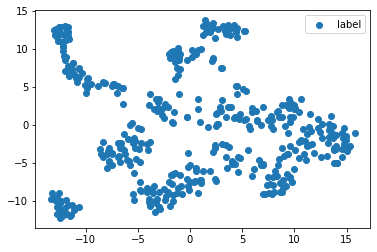

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figures/tsne_ae_gdsc.png")

In [ ]:
EPOCH = 500

In [ ]:
# Load data
# data type conversion
B_feature = torch.FloatTensor(feature).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
# construct TensorDataset
b_data = TensorDataset(B_feature, y)
trainDataLoader2 = DataLoader(dataset=b_data, batch_size=200, shuffle=False)

In [ ]:
# Initialization DNN model

predictor = DNN(128, dim_dnn_out).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=1e-3,betas=(0.9,0.99))
#loss1-softmax
loss_func = nn.MSELoss().to(device)
#loss2-sigmoid
#loss_func = nn.BCELoss()
#loss3-sigmoid
#loss_func = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=True)
#criterion = torch.nn.BCELoss(size_average=True) # Defined loss function
#optimizer = optim.Adm(model.parameters(), lr=0.01) # Defined optimizer
loss_train = np.zeros((epochs, 1))

In [ ]:
# train model
for epoch in range(EPOCH):
    print('Epoch: ',epoch)
    for step,(batch_x,batch_y) in enumerate(trainDataLoader2):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        # predict label
        output = predictor(b_x)
        # b_y=F.sigmoid(b_y) 
        
        #print
        #print(output)
        #print(b_y)
        # compute loss
        loss = loss_func(output,b_y)
        #loss = criterion(output, b_y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item())) 

# Save model
torch.save(predictor.state_dict(), 'saved/models/DNN_GDSC.pkl')

In [ ]:
testpredict = predictor(testFeature)

In [ ]:
testpredict

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
r2_score(testpredict.detach().cpu().numpy(),Y_test)

In [ ]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)